In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from dviforbml.utils.helper import download_run_np
from collections import defaultdict
import os

In [ ]:
project = "cluster-np"

self_attn_num_heads = [None, 8]
context_variant = ["mean", "bca"]
model_variant = ["lnp", "cnp"]
trainer_variant = ["data"]
max_context_size = [None, 16]
z_dim = [2, 8]
seed = [0, 1]

group_ids = [
    "With Self-Attention",
    "Context Variant",
    "NP Variant",
    "Objective",
    "Seed",
]

names = [
    "-".join(map(str, values))
    for values in product(
        self_attn_num_heads, context_variant, model_variant, trainer_variant, seed
    )
]

# names.remove("16-None-10-bca-constr-cmcd-True")
# names.remove("16-4-None-bca-constr-ula-True")
# print(names)

In [3]:
from tqdm import tqdm

for name in tqdm(names):
    download_run_np(project, name)

  0%|          | 0/16 [00:00<?, ?it/s]wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
  6%|▋         | 1/16 [00:04<01:10,  4.72s/it]wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
 12%|█▎        | 2/16 [00:08<00:59,  4.27s/it]wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
 19%|█▉        | 3/16 [00:13<00:57,  4.40s/it]wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
 25%|██▌       | 4/16 [00:17<00:49,  4.15s/it]wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
 31%|███▏      | 5/16 [00:21<00:47,  4.28s/it]wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   

In [4]:
def group_names_by_index(names, index):
    grouped = defaultdict(list)
    for name in names:
        parts = name.split("-")
        if index < len(parts):
            key = parts[index]
            grouped[key].append(name)
    return dict(grouped)

In [ ]:
def group_names_custom(names, cv):
    grouped = defaultdict(list)

    for name in names:
        parts = name.split("-")

        self_attn = parts[1]
        context_size = parts[2]
        context_variant = parts[3]
        noise_variant = parts[4]
        model_variant = parts[5]
        contextual_schedules = parts[6]

        # Group 1
        if context_variant == cv and (
            model_variant == "dis"  # or model_variant == "cmcd"
        ):
            if self_attn == "None":
                if context_size == "None":
                    grouped["no_context_size_no_attn"].append(name)
                else:
                    grouped["with_context_size_no_attn"].append(name)
            else:
                if context_size == "None":
                    grouped["no_context_size_with_attn"].append(name)
                else:
                    grouped["with_context_size_with_attn"].append(name)

    return dict(grouped)

In [26]:
def group_names_custom2(names, dviv):
    grouped = defaultdict(list)

    for name in names:
        parts = name.split("-")

        self_attn = parts[1]
        context_size = parts[2]
        context_variant = parts[3]
        noise_variant = parts[4]
        model_variant = parts[5]
        contextual_schedules = parts[6]

        # Group 1
        if model_variant == dviv:
            if noise_variant == "free":
                if contextual_schedules == "True":
                    grouped["schedules_free_and_contextual"].append(name)
                elif contextual_schedules == "False":
                    grouped["schedules_free_and_not_contextual"].append(name)
            elif noise_variant == "constr":
                if contextual_schedules == "True":
                    grouped["schedules_constr_and_contextual"].append(name)
                elif contextual_schedules == "False":
                    grouped["schedules_constr_and_not_contextual"].append(name)

    return dict(grouped)

In [6]:
import math


def average_group_data(grouped_names):
    averaged_data = {}

    for group_value, name_list in grouped_names.items():
        data_frames = []

        for name in name_list:
            file_path = f"../models/{project}/{name}/metrics.csv"
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                df = df.rename(columns={df.columns[0]: "index"})
                data_frames.append(df)
            else:
                print(f"Missing file: {file_path}")

        if data_frames:
            # Merge and average by 'index'
            all_df = pd.concat(data_frames)
            avg_df = all_df.groupby("index").mean().reset_index()
            averaged_data[group_value] = avg_df

    return averaged_data


def plot_group_averages(averaged_data, i, value_column="jsds"):
    plt.figure(figsize=(4, 2))
    for group_name, df in averaged_data.items():
        plt.plot(df["index"], df[value_column], label=group_name, marker="o")

    plt.xlabel("Context Size")
    plt.ylabel("Average JSD")
    plt.title(f"{group_ids[i]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(f"{group_ids[i]}.pdf")
    plt.show()

dict_keys(['schedules_free_and_contextual', 'schedules_free_and_not_contextual', 'schedules_constr_and_contextual', 'schedules_constr_and_not_contextual'])
dict_keys(['schedules_free_and_contextual', 'schedules_free_and_not_contextual', 'schedules_constr_and_contextual', 'schedules_constr_and_not_contextual'])


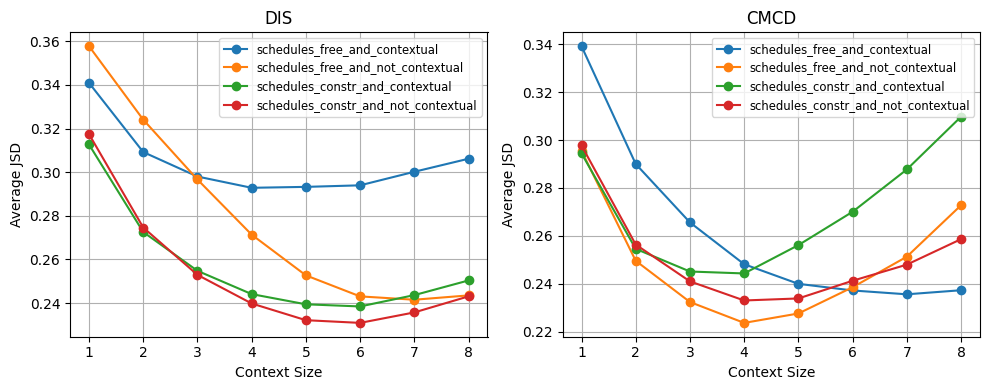

In [27]:
fig, axes = plt.subplots(
    1, 2, figsize=(10, 4)
)  # 6 plots total (since we're skipping one)
axes = axes.flatten()

cvs = ["dis", "cmcd"]

for ax, cv in zip(axes, cvs):
    grouped = group_names_custom2(names, cv)
    print(grouped.keys())
    average_data = average_group_data(grouped)

    for group_name, df in average_data.items():
        label = group_name

        ax.plot(df["index"], df["jsds"], label=label, marker="o")

    ax.set_title("DIS" if cv == "dis" else "CMCD")
    ax.set_xlabel("Context Size")
    ax.set_ylabel("Average JSD")
    ax.grid(True)
    ax.legend(fontsize="small")

plt.tight_layout()
plt.savefig("ahh.pdf")
plt.show()

dict_keys(['no_context_size_no_attn', 'with_context_size_no_attn', 'no_context_size_with_attn', 'with_context_size_with_attn'])
dict_keys(['no_context_size_no_attn', 'with_context_size_no_attn', 'no_context_size_with_attn', 'with_context_size_with_attn'])


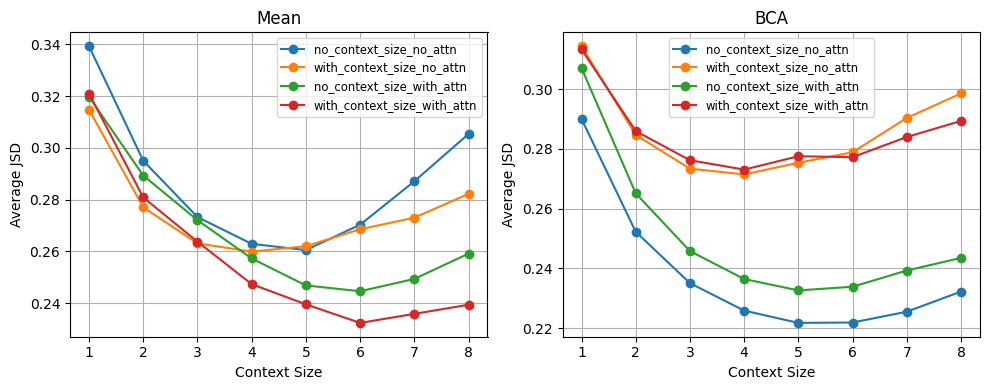

In [ ]:
fig, axes = plt.subplots(
    1, 2, figsize=(10, 4)
)  # 6 plots total (since we're skipping one)
axes = axes.flatten()

cvs = ["mean", "bca"]

for ax, cv in zip(axes, cvs):
    grouped = group_names_custom(names, cv)
    print(grouped.keys())
    average_data = average_group_data(grouped)

    for group_name, df in average_data.items():
        label = group_name

        ax.plot(df["index"], df["jsds"], label=label, marker="o")

    ax.set_title("Mean" if cv == "mean" else "BCA")
    ax.set_xlabel("Context Size")
    ax.set_ylabel("Average JSD")
    ax.grid(True)
    ax.legend(fontsize="small")

plt.tight_layout()
plt.savefig("ahh.pdf")
plt.show()

dict_keys(['None', '4'])
dict_keys(['None', '10'])
dict_keys(['mean', 'max', 'bca'])
dict_keys(['free', 'constr'])
dict_keys(['dis', 'dis_score', 'cmcd', 'ula'])
dict_keys(['True', 'False'])


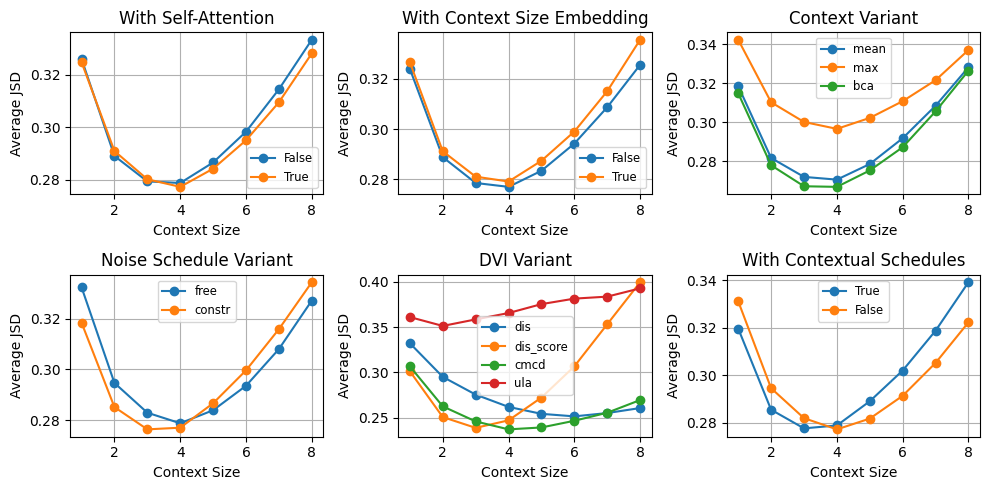

In [25]:
fig, axes = plt.subplots(
    2, 3, figsize=(10, 5)
)  # 6 plots total (since we're skipping one)
axes = axes.flatten()

plot_indices = [i for i in range(7) if i != 0]  # exclude index 0

for ax, i in zip(axes, plot_indices):
    grouped = group_names_by_index(names, i)
    print(grouped.keys())
    average_data = average_group_data(grouped)

    for group_name, df in average_data.items():
        if i == 1:
            if group_name == "4":
                label = "True"
            else:
                label = "False"
        elif i == 2:
            if group_name == "10":
                label = "True"
            else:
                label = "False"
        else:
            label = group_name

        ax.plot(df["index"], df["jsds"], label=label, marker="o")

    ax.set_title(group_ids[i])
    ax.set_xlabel("Context Size")
    ax.set_ylabel("Average JSD")
    ax.grid(True)
    ax.legend(fontsize="small")

plt.tight_layout()
plt.savefig("grouped_averages_grid_no_index0.pdf")
plt.show()

In [ ]:
# for i in range(7):
#     grouped = group_names_by_index(names, i)
#     average_data = average_group_data(grouped)
#     plot_group_averages(average_data, i)

In [7]:
def get_avg_jsd_per_name(names):
    avg_jsd_map = {}

    for name in names:
        file_path = f"../models/{project}/{name}/metrics.csv"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df = df.rename(columns={df.columns[0]: "index"})
            avg_jsd = df["jsds"].mean()
            avg_jsd_map[name] = avg_jsd
        else:
            print(f"Missing file: {file_path}")

    return avg_jsd_map


def plot_top_n_jsd(names, top_n=4):
    avg_jsd_map = get_avg_jsd_per_name(names)

    # Sort names by average jsd
    top_names = sorted(avg_jsd_map, key=avg_jsd_map.get)[:top_n]

    plt.figure(figsize=(6, 4))
    for name in top_names:
        file_path = f"../models/{project}/{name}/metrics.csv"
        df = pd.read_csv(file_path)
        df = df.rename(columns={df.columns[0]: "index"})
        plt.plot(
            df["index"],
            df["jsds"],
            marker="o",
            label=f"{name} (avg={avg_jsd_map[name]:.3f})",
        )

    plt.xlabel("Context Size Index")
    plt.ylabel("JSD")
    plt.title(f"Top {top_n} Models with Best Average JSD")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("top3.pdf")
    plt.show()

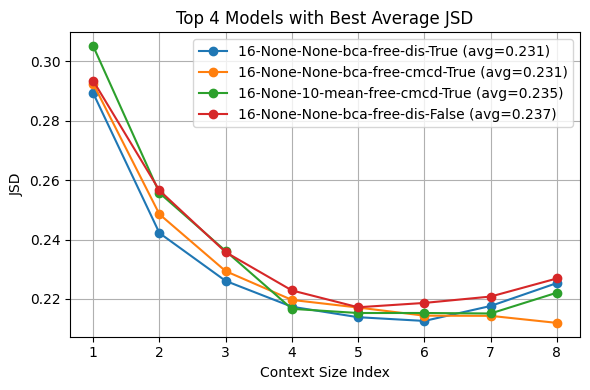

In [8]:
plot_top_n_jsd(names)

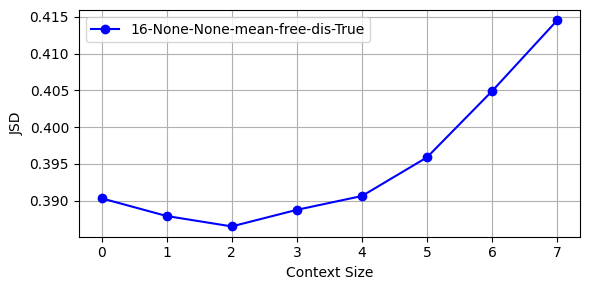

In [10]:
name = names[0]

figure = plt.figure(figsize=(6, 3))

df = pd.read_csv(f"../models/{project}/{name}/metrics.csv")
df.head

plt.plot(df.index, df["jsds"], marker="o", label=name, color="blue")

plt.xlabel("Context Size")
plt.ylabel("JSD")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()